In [1]:
# Load Modules
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import plotly.graph_objects as go
import ipywidgets as widgets
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import gc
import plotly.express as px
import matplotlib.pyplot as plt

In [ ]:
!git clone https://github.com/imaination/team_monaco_mda_2022.git
%cd ./team_monaco_mda_2022/data
!unzip ./Aqueduct\ Water\ Risk.csv.zip > /dev/null

Cloning into 'team_monaco_mda_2022'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 25 (delta 4), reused 22 (delta 3), pack-reused 0
Unpacking objects: 100% (25/25), done.
/content/team_monaco_mda_2022/data


In [ ]:
data_all = pd.read_csv('/content/team_monaco_mda_2022/data/Aqueduct Water Risk.csv', encoding = 'latin-1')
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}
data_all['name_1'] = data_all['name_1'].replace(us_state_abbrev)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning:

Columns (12,16,20,24,32,36,40,48) have mixed types.Specify dtype option on import or set low_memory=False.



In [ ]:
water_score = data_all.loc[data_all['gid_0'] == "USA"]
# keep only certain columns
water_score = water_score[['aq30_id','name_1', 'bws_score', 'bwd_score',  'sev_score', 'gtd_score',
            'rfr_score',  'drr_score',  'cep_score', 'udw_score', 'usa_score'#,'w_awr_def_tot_score' 'iav_score','cfr_score',
            ]]
water_score = water_score.sort_values('name_1')
#water_score = df22.replace(-9999, np.nan)
# drop rows having NA on score 'cep'
water_score.dropna(subset = ["cep_score"], inplace=True)
# Remove Hawaii
water_score = water_score[water_score.name_1 != "Hawaii"]

In [ ]:
#Helper Functions
#split train and test dataset based on prediction type
def select_target(data, target):
  if target == 'gtd_score':
    model_df = data[data['gtd_score'] != -9999].drop('drr_score',axis=1)
    test_set = data[data['gtd_score'] == -9999].drop('drr_score',axis=1)
    model_df = model_df.replace(-9999, np.nan)
    model_df.dropna(subset=['bws_score', 'bwd_score',  'sev_score', 'gtd_score',
            'rfr_score', 'cep_score', 'udw_score', 'usa_score'], inplace=True)
    model_df = model_df.reset_index(drop=True)
    test_set = test_set.reset_index(drop=True)

    
  elif target == 'drr_score':
    model_df = data[data['drr_score'] != -9999].drop('gtd_score',axis=1)
    test_set = data[data['drr_score'] == -9999].drop('gtd_score',axis=1)
    model_df = model_df.replace(-9999, np.nan)
    model_df.dropna(subset=['bws_score', 'bwd_score',  'sev_score', 
            'rfr_score',  'drr_score',  'cep_score', 'udw_score', 'usa_score'], inplace=True)
    model_df = model_df.reset_index(drop=True)
    test_set = test_set.reset_index(drop=True)
  return model_df, test_set

# lightgbm regression model with kfold cross-validation
def model(features_train, features_test, target, n_folds=5, scaler=MinMaxScaler()):
    
    train_ids = features_train['name_1']
    test_ids = features_test['name_1']
    test_aq30_id = features_test['aq30_id']
    targets = features_train[target]
    features_train =features_train.drop([target, 'name_1', 'aq30_id'], axis=1)
    features_test = features_test.drop([target, 'name_1', 'aq30_id'], axis=1)
    #features_train, features_test = features_train.align(features_test, join='inner', axis=1)
    print('training data shape:', features_train.shape)
    print('testing data shape:', features_test.shape)
    
    feature_names = list(features_train.columns)
    features_train = np.array(features_train)
    features_test = np.array(features_test)
    feature_importance_values = np.zeros(len(feature_names))
    test_predictions = np.zeros(features_test.shape[0])
    out_of_fold = np.zeros(features_train.shape[0])


    #create kfold object to maintain same class distribution
    kfold = KFold(n_splits = n_folds, shuffle=True, random_state=42)
    
    #iterate through each fold
    for train_indices, valid_indices in kfold.split(features_train, targets):
        tr_features, tr_targets = features_train[train_indices], targets[train_indices]
        val_features, val_targets = features_train[valid_indices], targets[valid_indices]

        #scale the features
        tr_features = scaler.fit_transform(tr_features)
        val_featuress= scaler.transform(val_features)
       
        model = lgb.LGBMRegressor(n_estimators=5000, objective='regression',
                                
                                   num_leaves=10,
                                       learning_rate=0.01, 
                                    
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                   random_state=42)
        #train the model
        model.fit(tr_features, tr_targets, eval_metric='mae', 
                  eval_set=[(val_features, val_targets), (tr_features, tr_targets)],
                  eval_names=['valid', 'train'],categorical_feature = 'auto', early_stopping_rounds=200, verbose=200)
        
        #record the best iteration
        best_iteration = model.best_iteration_
        #record the feature importance
        feature_importance_values += model.feature_importances_ / kfold.n_splits
        #make predictions
        test_predictions += model.predict(features_test, num_interation =best_iteration)/ kfold.n_splits
        #record the out of fold predictions
        out_of_fold[valid_indices] = model.predict(val_features, num_iteration=best_iteration)
        
        #clean up memory
        gc.enable()
        del model, tr_features, val_features
        gc.collect()
      
    
    
    #make feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    missing_value_prediction = pd.DataFrame({'state': test_ids, 'aq30_id' : test_aq30_id,'prediction': test_predictions})
    #overall validation score
    valid_rmse = mean_absolute_error(targets, out_of_fold)
    #valid_rmse =mean_squared_error(targets, out_of_fold, squared=False)
    print('overall validation score')
    print(valid_rmse)

    return  missing_value_prediction, feature_importances

#plot normalised feature importance
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (14, 8))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:20]))), 
            df['importance_normalized'].head(20), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:20]))))
    ax.set_yticklabels(df['feature'].head(20))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

In [ ]:
def prediction(data, target):
  model_df, test_set = select_target(data, target)
  missing_value_prediction, fi= model(model_df, test_set, target)
  fi_sorted = plot_feature_importances(fi)

  df_geo = missing_value_prediction.groupby('state').agg({'prediction':'mean'})
  df_geo = df_geo.reset_index()
  fig = go.Figure()
  layout = dict(
    title_text = f'{target} prediction',
    geo_scope='usa')

  fig.add_trace(
    go.Choropleth(
        locations=df_geo.state,
        zmax=1,
        z = df_geo.prediction,
        locationmode = 'USA-states', # set of locations match entries in `locations`
        #lon = df5['Longitude'],
        #lat = df5['Latitude'],
        marker_line_color='grey',
        geo='geo',
        colorscale=px.colors.sequential.Blues))           
  fig.update_layout(layout)   
  fig.show()
  #US_NA_prediction = missing_value_prediction['aq30_id','prediction']
  missing_value_prediction.to_csv('US_NA_prediction.csv')
 

In [ ]:
picked = widgets.Dropdown(
  options=[('Groundwater table decline', 'gtd_score'), ('Drought risk', 'drr_score')],
  value='gtd_score',
  description='Water Risk Prediction:',
)
picked


Dropdown(description='Water Risk Prediction:', options=(('Groundwater table decline', 'gtd_score'), ('Drought …

training data shape: (3186, 7)
testing data shape: (235, 7)
Training until validation scores don't improve for 200 rounds.
[200]	train's l2: 0.190411	train's l1: 0.338067	valid's l2: 0.337832	valid's l1: 0.45802
[400]	train's l2: 0.131742	train's l1: 0.282573	valid's l2: 0.329059	valid's l1: 0.456474
Early stopping, best iteration is:
[304]	train's l2: 0.152099	train's l1: 0.303381	valid's l2: 0.330635	valid's l1: 0.45494
Training until validation scores don't improve for 200 rounds.
[200]	train's l2: 0.186016	train's l1: 0.337754	valid's l2: 0.319073	valid's l1: 0.449075
Early stopping, best iteration is:
[105]	train's l2: 0.246059	train's l1: 0.386416	valid's l2: 0.32479	valid's l1: 0.445378
Training until validation scores don't improve for 200 rounds.
[200]	train's l2: 0.189727	train's l1: 0.337923	valid's l2: 0.326717	valid's l1: 0.447608
[400]	train's l2: 0.128958	train's l1: 0.279081	valid's l2: 0.320176	valid's l1: 0.445506
Early stopping, best iteration is:
[332]	train's l2: 0

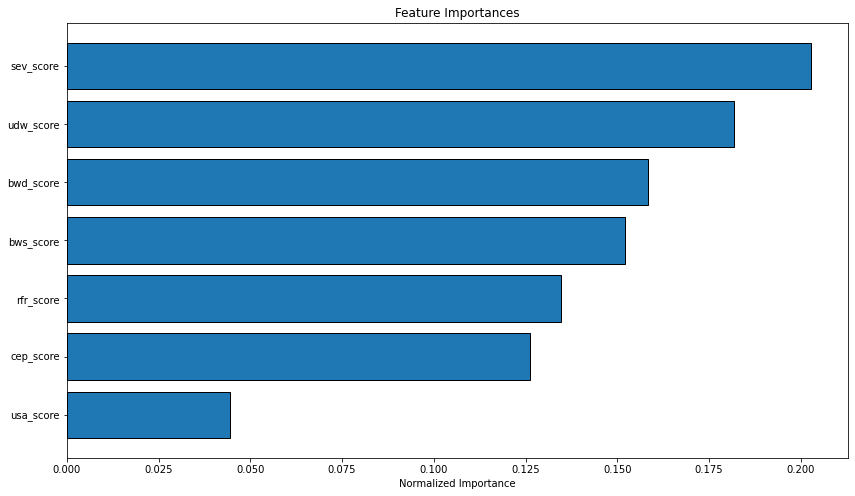

In [ ]:
prediction(water_score, picked.value)